# **Step 1: Problem Definition**

## Introduction to the Problem

In marketing and customer management, understanding customers and providing tailored products and services is crucial for businesses. However, meeting all customer needs with a single product or promotion is challenging. Therefore, businesses shift towards customer segmentation, focusing on specific groups based on unique characteristics.

With the rise of data science and technology, collecting and analyzing customer data has become a valuable resource, enabling businesses to make data-driven decisions. This helps improve marketing strategies and customer care, especially in highly competitive markets.

### *Why Use RFM Analysis?*
RFM analysis is a widely used customer segmentation technique in marketing. It evaluates customers based on three key factors:

- Recency: How recently a customer made a purchase.
- Frequency: How often a customer makes purchases.
- Monetary Value: How much money a customer spends.
By analyzing these factors, businesses can identify high-value customers, dormant customers, and potential churn risks.

### *Why K-Means++ Clustering?*
K-Means++ is an improved version of the traditional K-Means algorithm, which enhances the initialization of cluster centroids to achieve better clustering performance. This method helps to group customers into meaningful segments based on their RFM values.

## Dataset Description
The project uses a dataset of customer transactions extracted from the dataset of the company Adventure Works Cycles. This is a multinational company that manufactures and sells bicycles to the North American, European, and Asian markets. The extracted dataset records 121,253 transactions of the company from 07/01/2017 to 07/15/2020. This includes both individual customers and retailers. To analyze the optimal customer segment for each different market, this project filtered out the transactions made in the US (United States) market for use in further analysis.

# **Step 2: Data preparation and EDA**
Load, clean, and prepare data for further analysis and EDA.



## Import Necessary Libraries
Before processing the dataset, we need to import essential libraries for data handling, visualization, and clustering.

In [53]:
# Ensure required libraries are installed before running:
!pip install squarify scikit-learn-extra lifetimes

In [54]:
import pandas as pd
import numpy as np
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from lifetimes.utils import summary_data_from_transaction_data
from scipy import stats
from yellowbrick.cluster import SilhouetteVisualizer
from mpl_toolkits.mplot3d import Axes3D

## Load Dataset
The dataset contains multiple sheets representing various aspects of the business. I will extract and merge the relevant sheets to prepare a unified dataset for analysis.

In [55]:
file_url = 'https://docs.google.com/spreadsheets/d/1XDbHsEKYn65CX3s3uzq10IzevD4uIQJ1/export?format=xlsx'
data = pd.ExcelFile(file_url)
sales_data = data.parse('Sales_data')
customer_data = data.parse('Customer_data')
sales_order_data = data.parse('Sales Order_data')

Check Data Information: To ensure data consistency, we inspect the dataset structure, check for missing values, and analyze summary statistics.

In [56]:
sales_data.info()
customer_data.info()
sales_order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121253 entries, 0 to 121252
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SalesOrderLineKey        121253 non-null  int64  
 1   ResellerKey              121253 non-null  int64  
 2   CustomerKey              121253 non-null  int64  
 3   ProductKey               121253 non-null  int64  
 4   OrderDateKey             121253 non-null  int64  
 5   DueDateKey               121253 non-null  int64  
 6   ShipDateKey              119140 non-null  float64
 7   SalesTerritoryKey        121253 non-null  int64  
 8   Order Quantity           121253 non-null  int64  
 9   Unit Price               121253 non-null  float64
 10  Extended Amount          121253 non-null  float64
 11  Unit Price Discount Pct  121253 non-null  int64  
 12  Product Standard Cost    121253 non-null  float64
 13  Total Product Cost       121253 non-null  float64
 14  Sale

In summary, the data seems well-structured, but there are some missing values in the ShipDateKey column in the sales data. Howerver, we are not going to use ShipDateKey column for this project.

In [57]:
# Convert OrderDateKey from YYYYMMDD format to datetime
sales_data['OrderDateKey'] = pd.to_datetime(sales_data['OrderDateKey'], format='%Y%m%d', errors='coerce')

# Add a Year column derived from OrderDateKey
sales_data['Year'] = sales_data['OrderDateKey'].dt.year

In [58]:
# Filter rows where CustomerKey is -1
invalid_customers = sales_data[sales_data['CustomerKey'] == -1]

# Extract year from the 'OrderDateKey' (assuming it's in datetime format)
invalid_customers['Year'] = invalid_customers['OrderDateKey'].dt.year

# Group by year and count occurrences of invalid transactions
invalid_customer_count_by_year = invalid_customers.groupby('Year').size()

# Group by year to count total transactions for each year
total_transactions_by_year = sales_data.groupby('Year').size()

# Calculate the percentage of invalid transactions for each year
invalid_customer_percentage = (invalid_customer_count_by_year / total_transactions_by_year) * 100

# Combine the results into a single DataFrame
result = pd.DataFrame({
    'Invalid Transaction Count': invalid_customer_count_by_year,
    'Total Transactions': total_transactions_by_year,
    'Invalid Transaction %': invalid_customer_percentage
})

# Calculate the overall invalid transaction percentage across all years
overall_invalid_percentage = (invalid_customer_count_by_year.sum() / total_transactions_by_year.sum()) * 100

# Display the results
print("Invalid transaction statistics by year:")
print(result)

print(f"\nOverall invalid transaction percentage: {overall_invalid_percentage:.2f}%")


Invalid transaction statistics by year:
      Invalid Transaction Count  Total Transactions  Invalid Transaction %
Year                                                                      
2017                       4138                5339              77.505151
2018                      16676               19409              85.918904
2019                      26758               55542              48.176155
2020                      13283               40963              32.426824

Overall invalid transaction percentage: 50.19%


The output indicates that there are 60,855 rows in the sales_data where the CustomerKey is equal to -1. This likely represents invalid or missing customer records, as -1 may have been used as a placeholder or error value for invalid data entries.

## **Merge and clean data**
I will merge the sales data with customer and date information to create a complete dataset for analysis.




In [59]:
# Merge with customer data
sales_data = sales_data.merge(customer_data[['CustomerKey','Country-Region']],
                              on='CustomerKey', how='left')

# Merge SalesOrder_Data with Sales_data
sales_data = sales_data.merge(sales_order_data[['Sales Order', 'SalesOrderLineKey']], on='SalesOrderLineKey', how='left')

In [60]:
# Filter transactions to include only those in the United States
sales_data = sales_data[sales_data['Country-Region'] == 'United States']

In [61]:
# Drop unnecessary columns and ensure required columns exist
required_columns = ['Sales Order', 'CustomerKey', 'OrderDateKey', 'Order Quantity', 'Unit Price', 'Sales Amount', 'Year', 'Country-Region']
sales_data = sales_data[required_columns]

In [62]:
# Display the first few rows of the filtered data
print("Sample of the filtered data:")
print(sales_data.head())

# General info about the dataset
print("\nDataset Information:")
print(sales_data.info())

# Statistical summary for numerical columns
print("\nStatistical Summary of Numerical Columns:")
print(sales_data.describe())

# Count of missing values for each column
print("\nMissing Values in Each Column:")
print(sales_data.isnull().sum())

# Unique values in categorical columns
categorical_columns = ['Sales Order', 'CustomerKey', 'Country-Region', 'Year']
for col in categorical_columns:
    print(f"\nNumber of unique values in '{col}': {sales_data[col].nunique()}")



Sample of the filtered data:
      Sales Order  CustomerKey OrderDateKey  Order Quantity  Unit Price  \
60857     SO43699        25863   2017-07-01               1   3399.9900   
60858     SO43700        14501   2017-07-01               1    699.0982   
60860     SO43702        27645   2017-07-01               1   3578.2700   
60864     SO43706        27621   2017-07-02               1   3578.2700   
60865     SO43707        27616   2017-07-02               1   3578.2700   

       Sales Amount  Year Country-Region  
60857     3399.9900  2017  United States  
60858      699.0982  2017  United States  
60860     3578.2700  2017  United States  
60864     3578.2700  2017  United States  
60865     3578.2700  2017  United States  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 21344 entries, 60857 to 121241
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Sales Order     21344 n

-- Dataset Preview: Data consists of 21,344 transactions from 2017 to 2020, primarily from the U.S. Each order is a single-item transaction.

-- Dataset Info: No missing values, 8 columns, and data types are appropriate. Memory usage is low (1.4 MB).

-- Statistical Summary:
*   Sales Amount vary widely, with some high-value orders.
*   Most transactions are from 2019 and 2020.

-- Insights: Clean dataset with no missing values, ready for analysis. Significant variation in order value suggests a mix of small and large transactions.

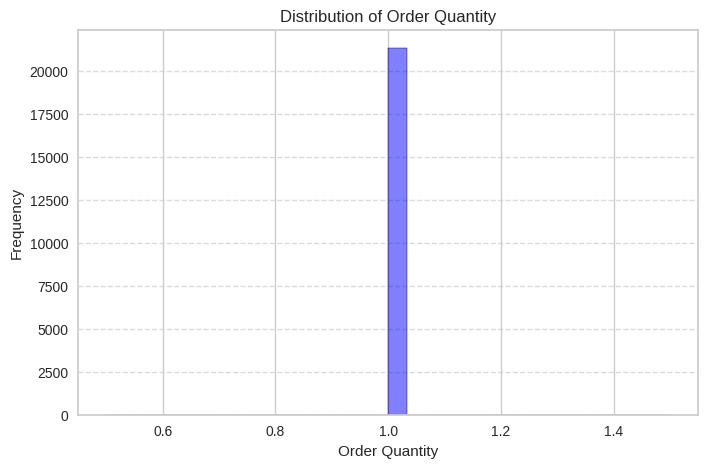

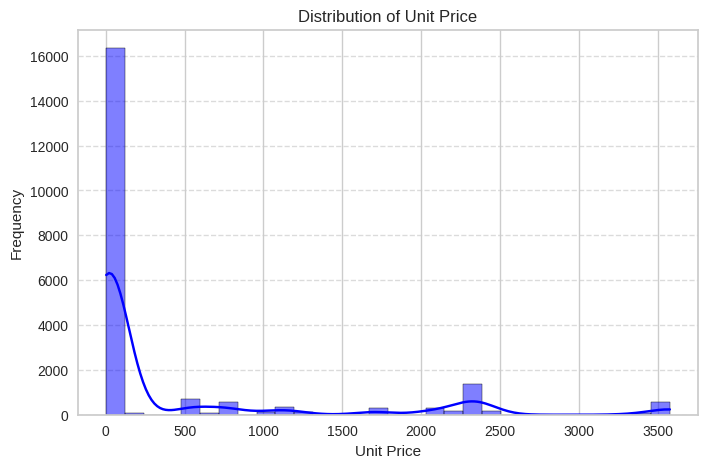

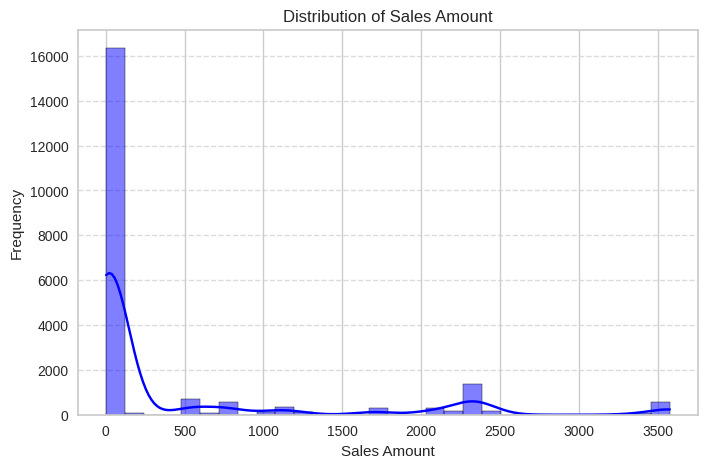

In [63]:
# Distribution plots for numerical columns
numerical_columns = ['Order Quantity', 'Unit Price', 'Sales Amount']
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(sales_data[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

- Nearly all transactions have an order quantity of 1, indicating single-item purchases across the dataset. There is no variability in the quantity.
- The distributions of Unit Price also Sales Amount are highly skewed to the left, with most items priced below 500, and a few high-value items with prices reaching up to 3,578. This suggests that the majority of orders are for lower-priced items, while a few high-value items contribute to the tail of the distribution, which may reflect a smaller portion of larger orders or specialized products.
The dataset is dominated by single-item, lower-priced transactions.

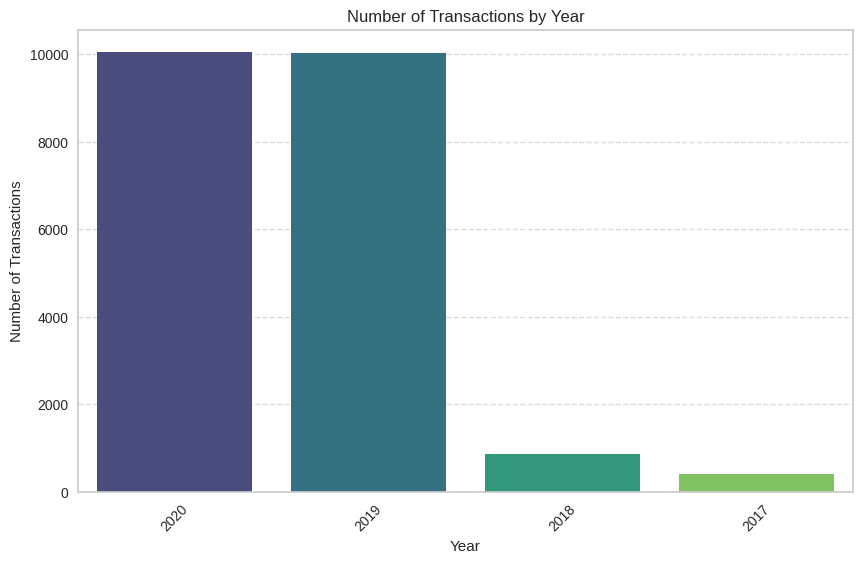

In [64]:
# Count plot for Year
plt.figure(figsize=(10, 6))
sns.countplot(data=sales_data, x='Year', palette='viridis', order=sales_data['Year'].value_counts().index)
plt.title("Number of Transactions by Year")
plt.xlabel("Year")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Adventure Works is a business that manufactures and sells bicycles to both individuals and resellers. Bicycles are non-essential, long-term products. Despite the higher transaction volumes observed in 2019 and 2020, a 4-year time scope has been selected for the analysis to ensure a comprehensive view of the business's performance over multiple years.

In [65]:
print(sales_data['OrderDateKey'].max())
print(sales_data['OrderDateKey'].min())

2020-06-15 00:00:00
2017-07-01 00:00:00


In [66]:
# Define the time scope: from 2017/07/15 to the latest date in the data
start_date = pd.to_datetime('2017/05/15')
end_date = sales_data['OrderDateKey'].max()  # Latest date in the dataset

# Filter the data for the defined time scope
sales_data = sales_data[(sales_data['OrderDateKey'] >= start_date) & (sales_data['OrderDateKey'] <= end_date)]

# Output the time scope for confirmation
print("Time Scope for Analysis:")
print(f"Start Date: {start_date.strftime('%Y-%m-%d')}")
print(f"End Date: {end_date.strftime('%Y-%m-%d')}")
print(f"Number of Transactions in this Time Scope: {sales_data.shape[0]}")


Time Scope for Analysis:
Start Date: 2017-05-15
End Date: 2020-06-15
Number of Transactions in this Time Scope: 21344


In [67]:
# Create a new dataset with reset index
cleaned_sales_data = sales_data.reset_index(drop=True)

In [68]:
# Add YearMonth column
cleaned_sales_data['YearMonth'] = cleaned_sales_data['OrderDateKey'].dt.to_period('M').astype(str)

In [69]:
# The first purchase date and the last purchase date
customer_summary = cleaned_sales_data.groupby('CustomerKey')['OrderDateKey'].agg(['min', 'max']).reset_index()
customer_summary.columns = ['CustomerKey', 'FirstPurchaseDate', 'LastPurchaseDate']

In [70]:
# Display the first few rows of the cleaned dataset
print(cleaned_sales_data.shape)

print("\nCleaned dataset sample:")
cleaned_sales_data.head()

(21344, 9)

Cleaned dataset sample:


,Sales Order,CustomerKey,OrderDateKey,Order Quantity,Unit Price,Sales Amount,Year,Country-Region,YearMonth
0,SO43699,25863,2017-07-01,1,3399.9900,3399.9900,2017,United States,2017-07
1,SO43700,14501,2017-07-01,1,699.0982,699.0982,2017,United States,2017-07
2,SO43702,27645,2017-07-01,1,3578.2700,3578.2700,2017,United States,2017-07
3,SO43706,27621,2017-07-02,1,3578.2700,3578.2700,2017,United States,2017-07
4,SO43707,27616,2017-07-02,1,3578.2700,3578.2700,2017,United States,2017-07


## Customer Retention and Sales Trend Analysis

In [71]:
# Count the number of transactions for each customer
purchase_counts = cleaned_sales_data.groupby('CustomerKey')['Sales Order'].nunique().reset_index()
purchase_counts.columns = ['CustomerKey', 'PurchaseCount']

# Classify customers as One-Time or Returning
purchase_counts['CustomerType'] = purchase_counts['PurchaseCount'].apply(
    lambda x: 'One-Time' if x == 1 else 'Returning'
)

# Calculate the percentage of each customer type
customer_percentage = purchase_counts['CustomerType'].value_counts(normalize=True) * 100
print("Customer Percentage:")
print(customer_percentage)

Customer Percentage:
CustomerType
One-Time     77.772094
Returning    22.227906
Name: proportion, dtype: float64


In [72]:
# Merge the original data with customer type:
merged_data = cleaned_sales_data.merge(
    purchase_counts[['CustomerKey', 'CustomerType']],
    on='CustomerKey'
)

# Calculate total sales by month and customer type
monthly_sales = merged_data.groupby(['YearMonth', 'CustomerType'])['Sales Amount'].sum().reset_index()

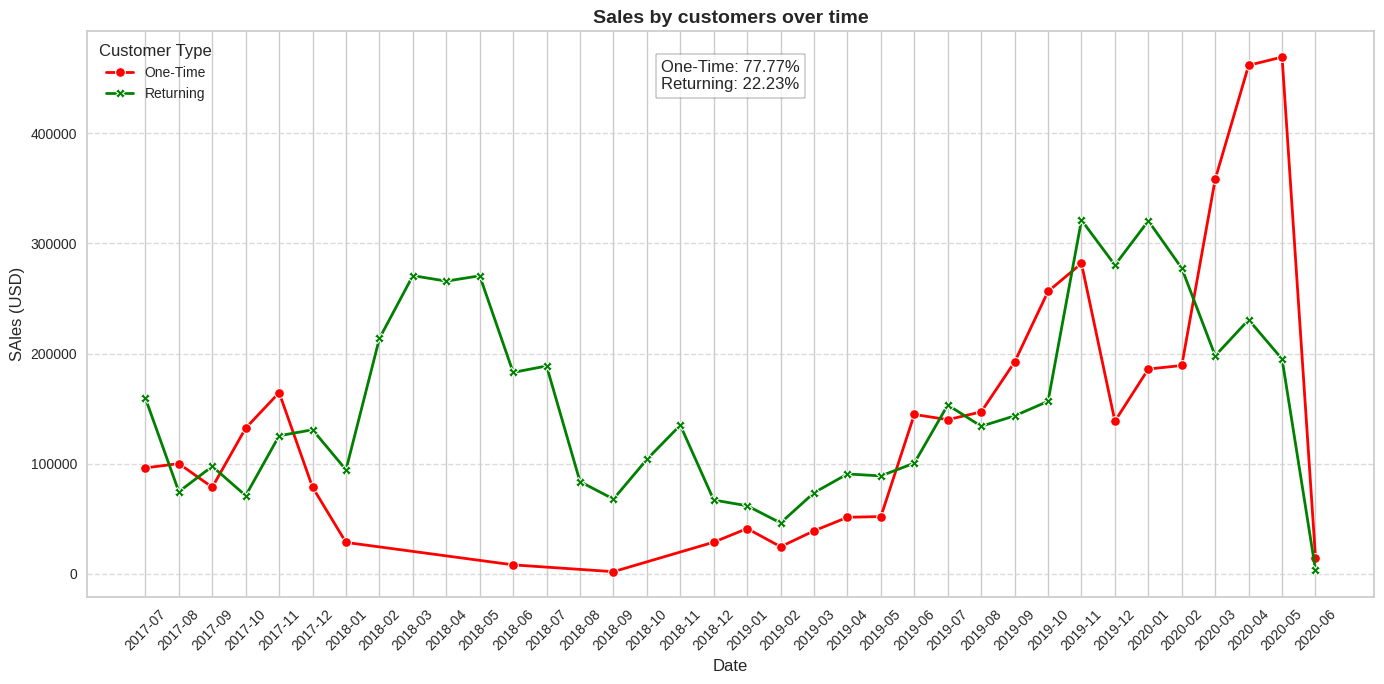

In [73]:
# Plot Sales by Customer Type Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=monthly_sales,
    x='YearMonth',
    y='Sales Amount',
    hue='CustomerType',
    style='CustomerType',
    markers=True,
    dashes=False,
    linewidth=2,
    palette={'One-Time': 'red', 'Returning': 'green'}
)

# Chart formatting
plt.title('Sales by customers over time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('SAles (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Customer Type', title_fontsize=12, fontsize=10)

# Display Customer Percentage on the Plot
plt.text(
    x=0.5,
    y=0.95,
    s=f'One-Time: {customer_percentage["One-Time"]:.2f}%\nReturning: {customer_percentage["Returning"]:.2f}%',
    transform=plt.gca().transAxes,
    ha='center',
    va='top',
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.show()

The majority of customers, 77.77%, made only one transaction over the past 3 years. However, the 22.23% who made repeat transactions generated higher revenue most of time, making them an important segment despite their smaller number.

Additionally, customers categorized as "returning" for having made two or more transactions may have done so a long time ago. Therefore, incorporating the time factor through RFM analysis is necessary.

## Retention Rate Visualization

In [74]:
# Get the first month of purchase for each customer
cleaned_sales_data['CohortMonth'] = cleaned_sales_data.groupby('CustomerKey')['OrderDateKey'].transform('min').dt.to_period('M')

# Get the transaction month for each purchase
cleaned_sales_data['TransactionMonth'] = cleaned_sales_data['OrderDateKey'].dt.to_period('M')

# Calculate the number of months between the transaction month and the first purchase month
cleaned_sales_data['CohortIndex'] = (cleaned_sales_data['TransactionMonth'].astype(int) - cleaned_sales_data['CohortMonth'].astype(int))

# Check the data
print(cleaned_sales_data[['CustomerKey', 'CohortMonth', 'TransactionMonth', 'CohortIndex']].head())


   CustomerKey CohortMonth TransactionMonth  CohortIndex
0        25863     2017-07          2017-07            0
1        14501     2017-07          2017-07            0
2        27645     2017-07          2017-07            0
3        27621     2017-07          2017-07            0
4        27616     2017-07          2017-07            0


In [75]:
# Count unique customers in each Cohort by CohortIndex
cohort_counts = cleaned_sales_data.groupby(['CohortMonth', 'CohortIndex'])['CustomerKey'].nunique().reset_index()

# Create a pivot table to display the data in the form of a Cohort Table matrix
cohort_pivot = cohort_counts.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerKey')

# Calculate the Retention Rate by dividing by the initial number of customers in each Cohort
cohort_retention = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0)

# Check the data
print(cohort_retention.head())

CohortIndex   0   1   2   3   4   5   6   7   8   9   ...        25        26  \
CohortMonth                                           ...                       
2017-07      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN       NaN   
2017-08      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN       NaN   
2017-09      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN  0.071429   
2017-10      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  0.016129  0.129032   
2017-11      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  0.089888  0.089888   

CohortIndex        27        28        29        30        31        32  \
CohortMonth                                                               
2017-07           NaN  0.087500  0.087500  0.037500       NaN  0.012500   
2017-08      0.018519  0.111111  0.092593       NaN       NaN  0.037037   
2017-09      0.142857  0.017857  0.017857       NaN       NaN  0.339286   
2017-10           NaN  0.080645  0.016129  0.016129  0.01

This code calculates cohort analysis by determining the first purchase month for each customer, extracting the transaction month for each purchase, and calculating the CohortIndex, which represents the number of months since the first purchase. This is useful for analyzing customer behavior over time.

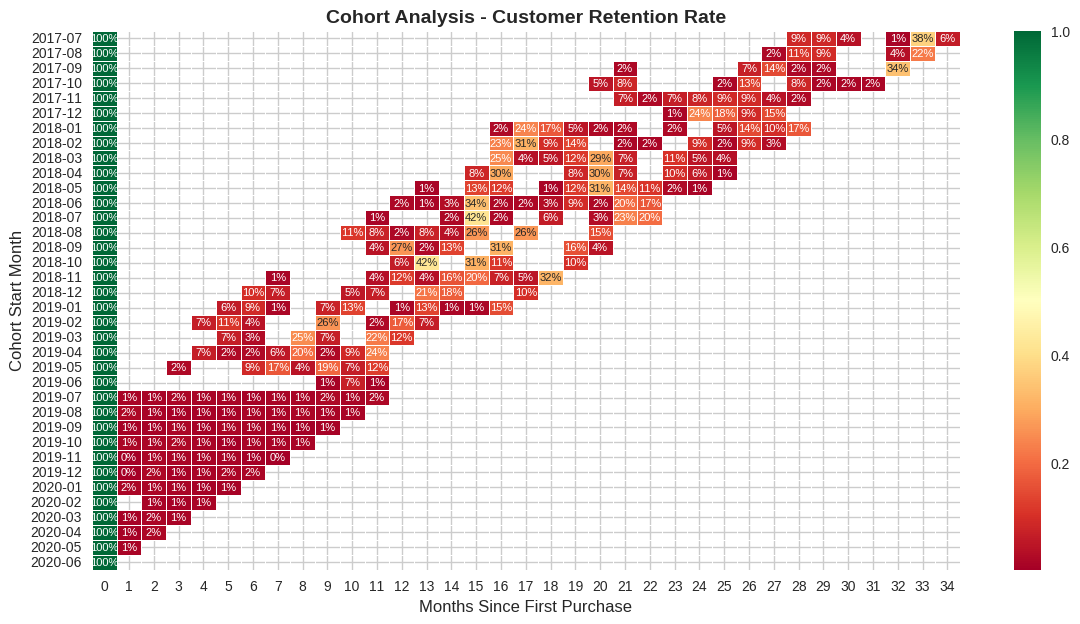

In [76]:
plt.figure(figsize=(14, 7))
sns.heatmap(
    cohort_retention,
    annot=True,
    fmt=".0%",
    cmap="RdYlGn",
    linewidths=0.5,
    annot_kws={"size": 8}  # Giảm kích thước font chữ tại đây
)

# Chart formatting
plt.title('Cohort Analysis - Customer Retention Rate', fontsize=14, fontweight='bold')
plt.xlabel('Months Since First Purchase', fontsize=12)
plt.ylabel('Cohort Start Month', fontsize=12)
plt.yticks(rotation=0)

plt.show()

The heatmap provides insights into customer retention rates for bicycles and accessories, which are non-essential, long-lasting products.

**1. Initial Retention:**

- Customers who made their first purchase of bicycles earlier (in 2017-2018) show a higher retention rate in the following months. This could reflect initial interest or promotional campaigns that encouraged repeat purchases early on.
- However, as time progresses (especially in later cohorts), there is a decline in retention, which is typical for non-essential items like bicycles, as they are long-lasting products and do not require frequent repurchasing.

**2. Drop-off Over Time:**

- Given the nature of bicycles being durable products, it’s expected that customers will not return frequently. After the initial purchase, many customers may not buy another bicycle for several years, leading to the sharp drop-off in retention beyond the first few months.
The early retention might indicate interest in accessories, service, or related products, which could be leveraged for upselling or cross-selling opportunities.
Cohort Analysis Insights:

- The newer cohorts (2020 and later) show lower retention, which could indicate that customer engagement strategies may need improvement to keep customers interested in the long term.
A potential reason for this could be that once customers buy a bicycle, they may not have a need for another one in the short term. This suggests that businesses should focus on customer engagement beyond the initial purchase, such as offering bicycle maintenance, accessories, or loyalty programs to keep them coming back.

**3. Business Insights for Bicycle Products:**

- Focus on Customer Loyalty: While many customers may not need a second bicycle soon, businesses should find ways to engage them through maintenance services, accessories, or promotions for future purchases.
- Seasonal and Usage-Based Engagement: As bicycles are long-term products, engagement efforts should be more seasonal (e.g., during spring/summer months) or based on the usage cycle of the product (e.g., after a year of use).
Retention Strategies for Non-Essential Products: With non-essential products like bicycles, targeted retention efforts such as offering product upgrades, bike accessories, or related services (like repairs or warranties) can help maintain customer interest.

# **Step 3: Calculate RFM Metrics**



### Group data by Sales Order to prepare for RFM analysis

In [77]:
aggregated_sales_data = cleaned_sales_data.groupby('Sales Order').agg(
    CustomerKey=('CustomerKey', 'first'),
    OrderDateKey=('OrderDateKey', 'first'),
    Sales_Amount=('Sales Amount', 'sum')
).reset_index()

### Define Metrics
Calculate Recency, Frequency, and Monetary values.

In [78]:
reference_date = aggregated_sales_data['OrderDateKey'].max()
rfm = aggregated_sales_data.groupby('CustomerKey').agg(
    Recency=('OrderDateKey', lambda x: (reference_date - x.max()).days),
    Frequency=('Sales Order', 'count'),
    Monetary=('Sales_Amount', 'sum')
).reset_index()

In [79]:
# Set CustomerKey as the index
rfm.set_index('CustomerKey', inplace=True)

#View sample RFM dataset
rfm.head(10)

,Recency,Frequency,Monetary
CustomerKey,,,
11012,90,2,81.26
11013,3,2,113.96
11014,258,2,138.45
11015,360,1,2500.97
11016,338,1,2332.28
11021,355,1,2371.96
11022,358,1,2322.28
11023,7,2,122.24
11024,171,2,56.51


In [80]:
# Filter sales data for CustomerKey 11012
#customer_11014_orders = cleaned_sales_data[cleaned_sales_data['CustomerKey'] == 11014]

# Extract the distinct Sales Orders for this customer
#distinct_sales_orders = customer_11014_orders['Sales Order'].unique()

# Print the Sales Orders
#print("Sales Orders for CustomerKey 11014:")
#print(distinct_sales_orders)

## Check Distribution of RFM Variables
Perform statistical analysis and visualize key data insights.


In [81]:
rfm.describe()

,Recency,Frequency,Monetary
count,7819.000000,7819.000000,7819.000000
mean,189.318967,1.223558,1200.893914
std,165.182035,0.419714,1680.927491
min,0.000000,1.000000,2.290000
25%,77.000000,1.000000,39.980000
50%,165.000000,1.000000,123.980000
75%,261.000000,1.000000,2071.419600
max,1078.000000,3.000000,6770.600000


The average last purchased date is 18 days ago with nearly 1.2 purchases and 1200.9 revenue in total.

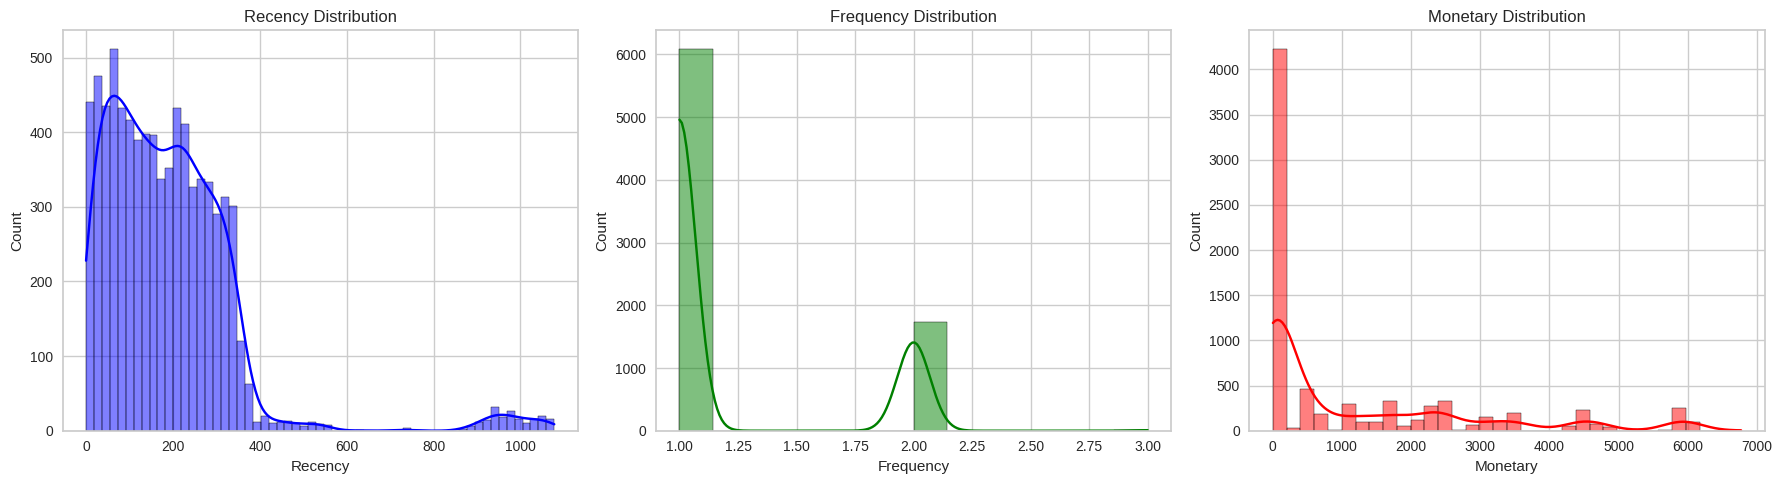

In [82]:
# Visualize Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['Recency'], kde=True, ax=axes[0], color='blue').set_title('Recency Distribution')
sns.histplot(rfm['Frequency'], kde=True, ax=axes[1], color='green').set_title('Frequency Distribution')
sns.histplot(rfm['Monetary'], kde=True, ax=axes[2], color='red').set_title('Monetary Distribution')
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Attributes')

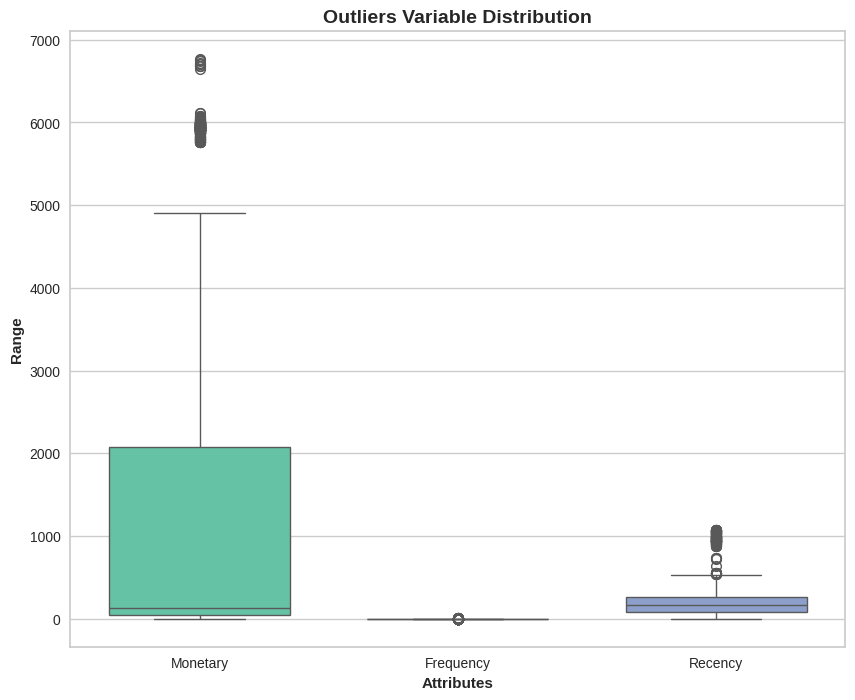

In [83]:
# Outlier Analysis of Monetary, Frequency and Recency

attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

- Customer Behavior: The data shows that most customers have made only one or two recent transactions, suggesting that engagement strategies should focus on turning occasional buyers into repeat customers.
- High-Value Customers: There is a small group of high-value customers contributing significantly to revenue, and it's important to identify and retain these customers.
- Improving Engagement: Given the skewed distributions, businesses can improve customer retention through targeted efforts, focusing on both frequent buyers and those with high spending.

## RFM Analysis
Customers with the most recent transactions receive a R score of 1, while those with the least recent transactions get a R score of 4, as recent buyers are more valuable to the business. The same method is used for Frequency and Monetary scores, but in reverse: the highest frequency and monetary values get a score of 4, and the lowest get a score of 1. The overall RFM score reflects customer value. Customers with an RFM score of 111 are the worst valuable, while those with an RFM score of 444 are the most valuable to the company.

In [84]:
rfm['RScore']=pd.qcut(rfm['Recency'],4,labels=[4,3,2,1])
rfm['FScore']=pd.qcut(rfm['Frequency'].rank(method='first'),4,labels=[1,2,3,4])
rfm['MScore']=pd.qcut(rfm['Monetary'],4,labels=[1,2,3,4])
rfm.head()

,Recency,Frequency,Monetary,RScore,FScore,MScore
CustomerKey,,,,,,
11012,90,2,81.26,3,4,2
11013,3,2,113.96,4,4,2
11014,258,2,138.45,2,4,3
11015,360,1,2500.97,1,1,4
11016,338,1,2332.28,1,1,4


In [85]:
rfm['RFM_Score'] = rfm['RScore'].astype(str) + rfm['FScore'].astype(str) + rfm['MScore'].astype(str)
rfm.head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFM_Score
CustomerKey,,,,,,,
11012,90,2,81.26,3,4,2,342
11013,3,2,113.96,4,4,2,442
11014,258,2,138.45,2,4,3,243
11015,360,1,2500.97,1,1,4,114
11016,338,1,2332.28,1,1,4,114


In [86]:
# Function to segment customers based on RFM Score
def segment_customer(rfm_score):
    R, F, M = int(rfm_score[0]), int(rfm_score[1]), int(rfm_score[2])  # Convert RFM score to integers

    # Top Customers: Best customers across all RFM factors
    if R == 4 and F == 4 and M == 4:
        return 'Top Customers'

    # Active Customers: Regular buyers, high spending
    elif R >= 3 and F >= 3 and M >= 3:
        return 'Active Customers'

    # Emerging Customers: Recently acquired and showing potential
    elif R >= 3 and F >= 3 and M >= 1:
        return 'Emerging Customers'

    # Steady Customers: Unsteady but high spending
    elif R >= 2 and F >= 1 and M >= 3:
        return 'Unsteady Customers'

    # Customers At Risk: Previously frequent buyers and high spending but now inactive
    elif R <= 2 and M >= 3:
        return 'At-Risk Customers'

    # Potential Lost Customers: Low recent activity, moderate frequency & spending
    elif R <= 2 and F <= 2 and M <= 2:
        return 'Potential Lost Customers'

    # Inactive Customers: Customers with low Recency but still some engagement
    elif R <= 2 and F >= 2 and M >= 2:
        return 'Inactive Customers'

    # Lost Customers: Completely churned customers with no significant activity
    else:
        return 'Lost Customers'

# Apply segmentation
rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# Count customers in each segment
customer_segments = rfm['Segment'].value_counts(normalize=True) * 100

# Display segment distribution
print(customer_segments)


Segment
Unsteady Customers          23.519632
Lost Customers              20.616447
Potential Lost Customers    14.426397
At-Risk Customers           13.300934
Emerging Customers          10.947692
Active Customers            10.448907
Inactive Customers           4.246067
Top Customers                2.493925
Name: proportion, dtype: float64


In [87]:
rfm.head(50)

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFM_Score,Segment
CustomerKey,,,,,,,,
11012,90,2,81.26,3,4,2,342,Emerging Customers
11013,3,2,113.96,4,4,2,442,Emerging Customers
11014,258,2,138.45,2,4,3,243,Unsteady Customers
11015,360,1,2500.97,1,1,4,114,At-Risk Customers
11016,338,1,2332.28,1,1,4,114,At-Risk Customers
11021,355,1,2371.96,1,1,4,114,At-Risk Customers
11022,358,1,2322.28,1,1,4,114,At-Risk Customers
11023,7,2,122.24,4,4,2,442,Emerging Customers
11024,171,2,56.51,2,4,2,242,Inactive Customers


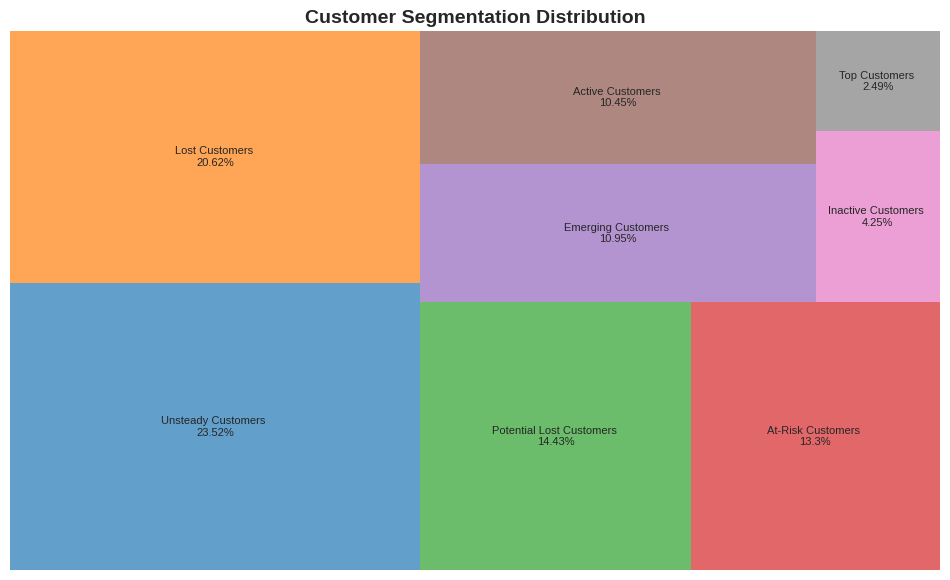

In [88]:
# Create treemap
plt.figure(figsize=(12, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
squarify.plot(
    sizes=customer_segments.values,
    label=[f"{seg} \n{round(pct, 2)}%" for seg, pct in customer_segments.items()],
    color=colors,
    alpha=0.7,
    text_kwargs={'fontsize': 8}
)

# Chart formatting
plt.axis('off')
plt.title("Customer Segmentation Distribution", fontsize=14, fontweight="bold")
plt.show()


## RFM Data Standarization

In [89]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize Recency, Frequency, and Monetary columns
scaled_rfm_values = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Convert to DataFrame and retain original index
scaled_rfm = pd.DataFrame(scaled_rfm_values, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

# Display the first few rows
scaled_rfm.head()

,Recency,Frequency,Monetary
CustomerKey,,,
11012,-0.601308,1.850047,-0.666124
11013,-1.128034,1.850047,-0.646669
11014,0.415817,1.850047,-0.632099
11015,1.033357,-0.532677,0.773477
11016,0.900162,-0.532677,0.673116


In [90]:
rfm.head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFM_Score,Segment
CustomerKey,,,,,,,,
11012,90,2,81.26,3,4,2,342,Emerging Customers
11013,3,2,113.96,4,4,2,442,Emerging Customers
11014,258,2,138.45,2,4,3,243,Unsteady Customers
11015,360,1,2500.97,1,1,4,114,At-Risk Customers
11016,338,1,2332.28,1,1,4,114,At-Risk Customers


#**Step 4 : Modeling - Customer Segmentation Using K-Means++**

## Determine the Optimal Number of Clusters (Elbow Method)
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

In [91]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=20 , random_state=42)
    kmeans.fit(scaled_rfm)
    ssd.append(kmeans.inertia_)

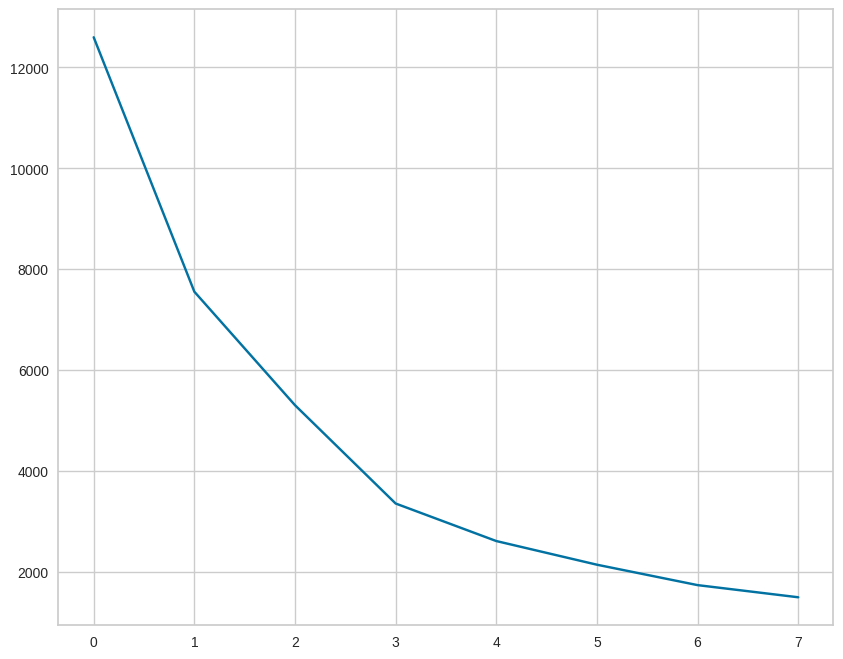

In [92]:
# plot the SSDs for each n_clusters
plt.plot(ssd)

## Determine the Optimal Number of Clusters (Silhouette Score)
The Silhouette Score evaluates clustering quality by measuring how similar an object is to its own cluster compared to other clusters.




In [93]:
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=20, random_state=42)
    kmeans.fit(scaled_rfm)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_rfm, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")

For n_clusters=2, the silhouette score is 0.5894948956225192
For n_clusters=3, the silhouette score is 0.6364868813671414
For n_clusters=4, the silhouette score is 0.6114102154275164
For n_clusters=5, the silhouette score is 0.48996502166923667
For n_clusters=6, the silhouette score is 0.5247956939392695
For n_clusters=7, the silhouette score is 0.5417258041912826
For n_clusters=8, the silhouette score is 0.521573144213006
For n_clusters=9, the silhouette score is 0.4945626407784729


## Apply K-Means Clustering

In [94]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=20, random_state=42)
kmeans.fit(scaled_rfm)

KMeans(n_clusters=3, n_init=20, random_state=42)

In [95]:
 kmeans.labels_

array([2, 2, 2, ..., 0, 1, 0], dtype=int32)

In [96]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFM_Score,Segment,Cluster_Id
CustomerKey,,,,,,,,,
11012,90,2,81.26,3,4,2,342,Emerging Customers,2
11013,3,2,113.96,4,4,2,442,Emerging Customers,2
11014,258,2,138.45,2,4,3,243,Unsteady Customers,2
11015,360,1,2500.97,1,1,4,114,At-Risk Customers,1
11016,338,1,2332.28,1,1,4,114,At-Risk Customers,1


In [97]:
def split_dataframe_by_column_value(df, column_name):

    # Group by column value
    grouped = df.groupby(column_name)

    # Create a dictionary to store sub-dataframes based on column values
    subframes = {}

    # Loop through each value and create a sub-dataframe for each value
    for value, group in grouped:
        subframes[value] = group.copy()

    return subframes

cluster = split_dataframe_by_column_value(rfm, 'Cluster_Id')

# **Step 5: Evaluation & Interpretation**

## Clusters discription & Visualization

In [98]:
cluster[0].describe()

,Recency,Frequency,Monetary,Cluster_Id
count,195.000000,195.0,195.000000,195.0
mean,974.164103,1.0,3537.689829,0.0
std,68.205524,0.0,239.879804,0.0
min,634.000000,1.0,2049.098200,0.0
25%,937.000000,1.0,3578.270000,0.0
50%,975.000000,1.0,3578.270000,0.0
75%,1028.000000,1.0,3578.270000,0.0
max,1078.000000,1.0,3578.270000,0.0


Cluster 0 (Bronze):

- Recency: Customers in this cluster are relatively less recent (mean: 974), with a high spread (max: 1078), suggesting they haven't purchased in a while.
- Monetary: The monetary values are high (mean: 3537), indicating that even though these customers have low frequency, their individual purchases are of significant value.
- Business Insight: These are high-value, low-frequency customers. Strategies could focus on re-engaging them, as they make substantial purchases when they do buy, possibly through targeted offers or loyalty programs.

In [99]:
cluster[1].describe()

,Recency,Frequency,Monetary,Cluster_Id
count,5886.000000,5886.0,5886.000000,5886.0
mean,172.469589,1.0,546.740967,1.0
std,111.116527,0.0,807.452574,0.0
min,0.000000,1.0,2.290000,1.0
25%,75.000000,1.0,34.980000,1.0
50%,164.000000,1.0,71.940000,1.0
75%,260.750000,1.0,618.980000,1.0
max,555.000000,1.0,2618.620000,1.0


Cluster 1 (Silver):

- Recency: Customers in this group are more recent (mean: 172), with a wide range of recency (min: 0). Some may have stopped purchasing.
- Monetary: The monetary values are moderate (mean: 547), showing a balance between frequency and spending, with a larger proportion of lower-value purchases.
- Business Insight: These are frequent, low-value customers. They may require incentives or promotions to increase spend and loyalty, such as upselling or personalized offers.

In [100]:
cluster[2].describe()

,Recency,Frequency,Monetary,Cluster_Id
count,1738.000000,1738.000000,1738.000000,1738.0
mean,158.323936,2.005754,3154.098194,2.0
std,96.852786,0.075657,2149.803399,0.0
min,0.000000,2.000000,37.290000,2.0
25%,75.000000,2.000000,1397.950000,2.0
50%,150.000000,2.000000,3248.965000,2.0
75%,224.000000,2.000000,4699.692500,2.0
max,379.000000,3.000000,6770.600000,2.0


Cluster 2 (Gold):

- Recency: Customers in this cluster are fairly recent (mean: 158), with moderate recency.
- Frequency: This group has the highest frequency (mean: 2.00), indicating customers who engage with the business regularly.
- Monetary: The monetary values are moderate to high (mean: 3154), suggesting that while they buy regularly, they may not spend as much as those in Cluster 0.
- Business Insight: These customers are loyal and regular, making them an important segment for long-term retention strategies. Businesses can further engage them by introducing premium memberships or exclusive rewards.

In [101]:
# Define new cluster labels
cluster_labels = {
    0: "Bronze",
    1: "Silver",
    2: "Gold"
}

# Map the labels to the dataframe
rfm['Cluster label'] = rfm['Cluster_Id'].map(cluster_labels)

The Silver group (Cluster 1) has the largest number of customers, but they have the lowest monetary value and only made purchases once. The Bronze group (Cluster 0) has fewer customers but a much higher monetary value, even though they haven't made purchases for a long time. Meanwhile, the Gold group (Cluster 2) consists of loyal, high-value customers who make frequent purchases. The distinction between Silver and Bronze is mainly based on their average recency values.

In [102]:
rfm.head(10)

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFM_Score,Segment,Cluster_Id,Cluster label
CustomerKey,,,,,,,,,,
11012,90,2,81.26,3,4,2,342,Emerging Customers,2,Gold
11013,3,2,113.96,4,4,2,442,Emerging Customers,2,Gold
11014,258,2,138.45,2,4,3,243,Unsteady Customers,2,Gold
11015,360,1,2500.97,1,1,4,114,At-Risk Customers,1,Silver
11016,338,1,2332.28,1,1,4,114,At-Risk Customers,1,Silver
11021,355,1,2371.96,1,1,4,114,At-Risk Customers,1,Silver
11022,358,1,2322.28,1,1,4,114,At-Risk Customers,1,Silver
11023,7,2,122.24,4,4,2,442,Emerging Customers,2,Gold
11024,171,2,56.51,2,4,2,242,Inactive Customers,2,Gold


Cluster Visualization: Scatter plot is used to visualize customer segments, highlighting key differences between clusters.



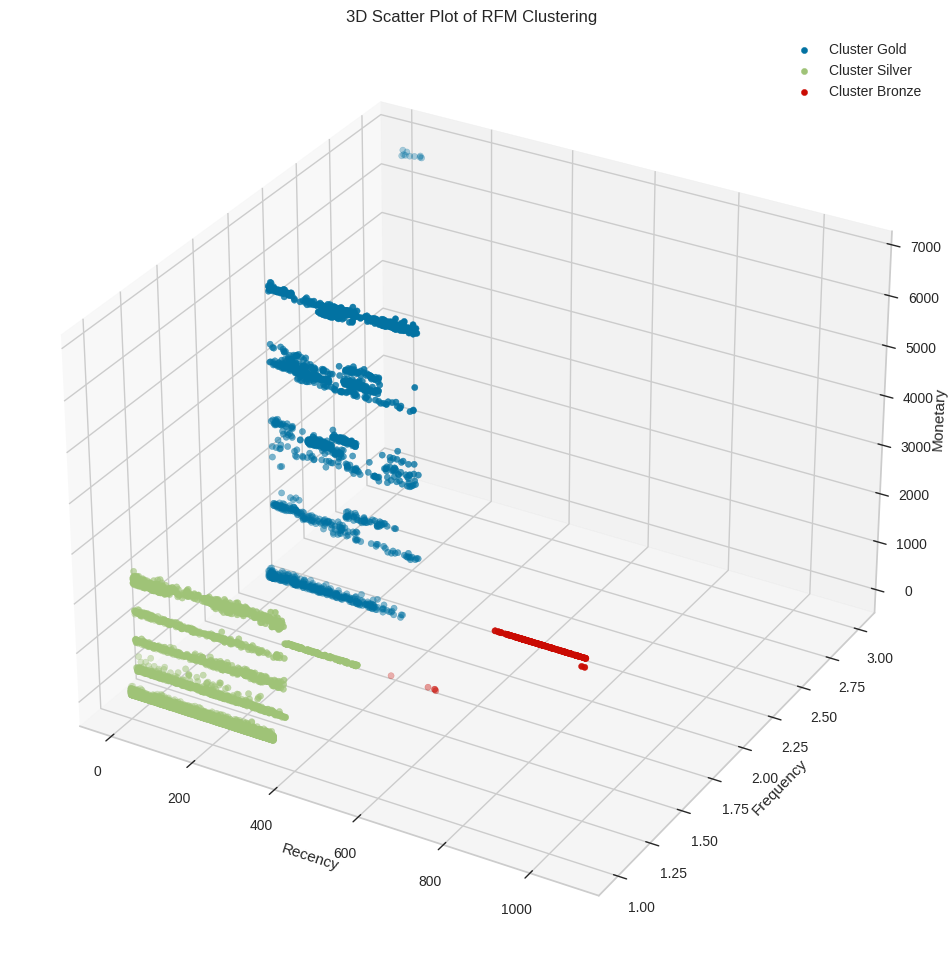

In [103]:
# Create a 3D figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points for each cluster
for cluster in rfm['Cluster label'].unique():
    cluster_data = rfm[rfm['Cluster label'] == cluster]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], label=f'Cluster {cluster}')

# Label the axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Clustering')

# Display the legend
ax.legend()

# Show the plot
plt.show()

The 3D scatter plot clearly shows that the model has effectively separated the customers into distinct clusters based on Recency, Frequency, and Monetary values.
This clear separation indicates that the clustering model is efficient in distinguishing different customer behaviors, enabling targeted marketing strategies for each group.

## Evaluation Metrics for Clustering Performance
I assess clustering quality using three key metrics:
- Silhouette Score (Higher is better, max=1): Measures how well data points fit within their clusters.
- Davies-Bouldin Score (Lower is better, min=0): Evaluates cluster compactness and separation.
- Calinski-Harabasz Score (Higher is better): Assesses the ratio of between-cluster to within-cluster dispersion.

In [104]:
# Extract the cluster labels from the RFM dataset
kmeans_data = rfm['Cluster_Id']  # Ensure 'Cluster' column exists

# Compute evaluation metrics
silhouette = silhouette_score(scaled_rfm, kmeans_data)
davies_bouldin = davies_bouldin_score(scaled_rfm, kmeans_data)
calinski_harabasz = calinski_harabasz_score(scaled_rfm, kmeans_data)

# Store results in a dictionary
evaluation_results = {
    "Silhouette Score": silhouette,
    "Davies-Bouldin Score": davies_bouldin,
    "Calinski-Harabasz Score": calinski_harabasz
}

# Convert to DataFrame for easy visualization
evaluation_df = pd.DataFrame([evaluation_results])

# Display results
print(evaluation_df)


   Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score
0          0.636487               0.56693              8227.645666


The Silhouette Score (0.636) indicates good cluster separation. The Davies-Bouldin Score (0.567) is low, suggesting well-separated clusters. The Calinski-Harabasz Score (8227.65) is high, confirming strong cluster separation. Overall, the model shows effective clustering with clear and distinct customer segments.